In [1]:
import sem
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

# Create our SEM campaign
ns_3_dir = '../../../'
script = 'aloha-throughput'
results_dir = 'aloha-results'
campaign = sem.CampaignManager.new(ns_3_dir, script, results_dir,
                                   check_repo=False, overwrite=True)

# Define the parameter space we are interested in exploring
params = {
    'nDevices': [1,3600,7200,10800,14440],
    'simulationTime': [round(i, 4) for i in np.logspace(0.5, 4, base=60, num=100, dtype='float')],
    'radius': [7500],
    'interferenceMatrix': lambda p: ["aloha"] if p["radius"] == 0 else ["goursaud"],
    'dutyCycle': [1]
}
runs = 10

# Run simulations with the above parameter space
campaign.run_missing_simulations(params, runs)

Running simulations: 100%|██████████| 5000/5000 [23:03<00:00,  3.61simulation/s]


In [19]:
example_result = campaign.db.get_complete_results()[4650]
display(example_result)
print(sem.utils.get_command_from_result('aloha-throughput', example_result))

{'params': {'nDevices': 14440,
  'simulationTime': 70713.6753,
  'radius': 7500,
  'interferenceMatrix': 'goursaud',
  'dutyCycle': 1,
  'RngRun': 4635},
 'meta': {'id': '0c915a18-9afa-49f5-a4d0-70f32af50ba6',
  'elapsed_time': 3.999176502227783,
  'exitcode': 0},
 'output': {'stdout': '2205 1698\n969 751\n1355 1079\n1961 1504\n1880 1407\n6070 3942\n',
  'durations.txt': '112895 205311 369663 657407 1478655 2629631 ',
  'stderr': ''}}

python3 waf --run "aloha-throughput --nDevices=14440 --simulationTime=70713.6753 --radius=7500 --interferenceMatrix=goursaud --dutyCycle=1 --RngRun=4635"


In [91]:
for example_result in campaign.db.get_complete_results():
display(example_result)
print(sem.utils.get_command_from_result('aloha-throughput', example_result))

{'params': {'nDevices': 4000,
  'simulationTime': 4519.4822,
  'radius': 7500,
  'interferenceMatrix': 'goursaud',
  'dutyCycle': 1,
  'RngRun': 1443},
 'meta': {'id': '095eb84c-6cd6-4c18-9012-21a7e3978237',
  'elapsed_time': 0.7274391651153564,
  'exitcode': 0},
 'output': {'stdout': '627 285\n280 113\n355 166\n548 227\n552 198\n1638 257\n',
  'durations.txt': '112895 205311 369663 657407 1478655 2629631 ',
  'stderr': ''}}

python3 waf --run "aloha-throughput --nDevices=4000 --simulationTime=4519.4822 --radius=7500 --interferenceMatrix=goursaud --dutyCycle=1 --RngRun=1443"


In [67]:
@sem.utils.output_labels(['G', 'S'])
def get_throughput(result):
    """
    Extract the probability of success from the simulation output
    """
    durations = [float(i)/1e6 for i in result['output']['durations.txt'].split()]
    sent = 0
    g = 0
    s = 0
    sf = 7
    for sf_performance in result['output']['stdout'].splitlines():
        sent, received = [float(i) for i in sf_performance.split()]
        current_g = sent * durations[sf-7] / result['params']['simulationTime']
        g += current_g
        if sent == 0:
            s += 0
        else:
            s += current_g * received / sent
        sf += 1
    return [g, s]
    
    


In [37]:
@sem.utils.output_labels(['Devices', 'Prob'])
def get_Succ(result):
    """
    Extract the probability of success from the simulation output
    """
    sent = 0
    received = 0
    avgPlace = []
    for sf_performance in result['output']['stdout'].splitlines():
        sent, received = [float(i) for i in sf_performance.split()]
        if sent == 0:
            continue
        else:
            prob = received/sent
        avgPlace.append(prob)

    avg = sum(avgPlace)/len(avgPlace) 
    return [result['params']['nDevices'], avg]
    

In [82]:
results = campaign.get_results_as_dataframe(get_throughput,
                                            params=params)

In [50]:
results = campaign.get_results_as_dataframe(get_Succ,
                                            params=params)

In [83]:
results = results.join(results.groupby(list(params.keys()))['G'].mean(), on=list(params.keys()), rsuffix='_avg')

In [57]:

# results = results.join(results.groupby(list(params.keys()))['Devices'].mean(), on=list(params.keys()), rsuffix='_avg')
results = results.groupby('Devices', as_index=False)['Prob'].mean()
print(results)

   Devices      Prob
0        1  1.000000
1     3600  0.525326
2     7200  0.477330
3    10800  0.449532
4    14440  0.429501


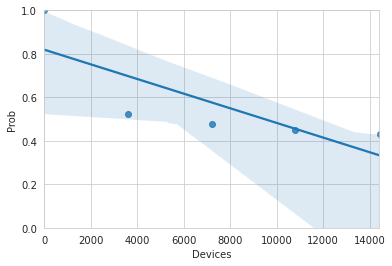

In [64]:
sns.regplot(data=results,
            x='Devices', 
            y='Prob',
            )
plt.ylim([0, 1])
plt.xlim([0, 14400])
plt.show()

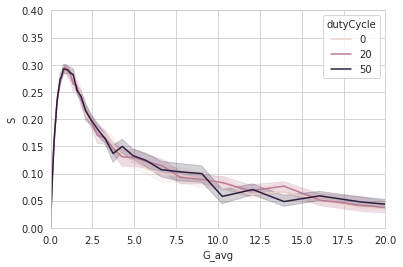

In [70]:
sns.lineplot(data=results,
            x='G_avg', 
            y='S',
            hue='dutyCycle')
plt.ylim([0, 0.4])
plt.xlim([0, 20])
plt.show()